In [1]:
## Import dependencies
# Standard libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from Bio import SeqIO

# PyTorch libraries
import torch

# ESM3 and ESMC libraries
import esm
from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESM3InferenceClient, ESMProtein, GenerationConfig
from esm.models.esmc import LogitsConfig, LogitsOutput

In [2]:
# Load sklearn libraries for PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

N_KMEANS_CLUSTERS = 3

In [ ]:
# Load the ESM-C embeddings
embeddings_path = "/home/azureuser/cloudfiles/code/Users/jc62/projects/direct_sequence_analysis/data/embeddings/target_search/antiphage_sequences_embeddings.pt"
embeddings = torch.load(embeddings_path)

/tmp/ipykernel_9628/3433203524.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(embeddings_path)
/tmp/ipykernel_9628/3433203524.py:5: FutureWarnin

In [20]:
# Compute and stack the mean embeddings
def mean_and_stack_embeddings(embeddings):
    embeddings_mean = [torch.mean(embeddings, dim=-2).squeeze() for embeddings in embeddings]
    stacked_mean_embeddings = torch.stack(embeddings_mean, dim=0)
    stacked_mean_embeddings_float32 = stacked_mean_embeddings.to(dtype=torch.float32).numpy()
    return stacked_mean_embeddings_float32

In [25]:
embeddings_orf_path = "/home/azureuser/cloudfiles/code/Users/jc62/projects/direct_sequence_analysis/data/embeddings/target_search/orf1_and_2_sections_embeddings.pt"
embeddings_orf = torch.load(embeddings_orf_path)
stacked_mean_embeddings_orf_float32 = mean_and_stack_embeddings(embeddings_orf)

/tmp/ipykernel_9628/891374517.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_orf = torch.load(embeddings_orf_path)


In [26]:
# Compute mean embeddings 
stacked_mean_embeddings_float32 = mean_and_stack_embeddings(embeddings)
stacked_mean_embeddings_orf_float32 = mean_and_stack_embeddings(embeddings_orf)
# stacked_mean_embeddings_all = stacked_mean_embeddings_float32

# Concatenante embeddings
stacked_mean_embeddings_all = np.concatenate((stacked_mean_embeddings_float32, stacked_mean_embeddings_orf_float32), axis=0)

In [28]:
len(embeddings_orf)

7

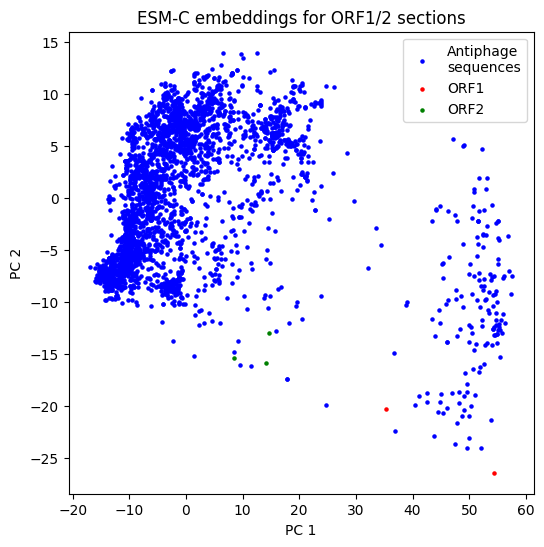

In [33]:
# project all the embeddings to 2D using PCA
pca = PCA(n_components=2)
pca.fit(stacked_mean_embeddings_all)
projected_mean_embeddings = pca.transform(stacked_mean_embeddings_all)
projected_mean_embeddings_enumerate = enumerate(projected_mean_embeddings)

# plot the clusters using matplotlib
plt.figure(figsize=(6, 6))
plt.scatter(
    projected_mean_embeddings[:-7, 0],
    projected_mean_embeddings[:-7, 1],
    s=5,
    color='blue',
    label="Antiphage\nsequences"
)

plt.scatter(
    projected_mean_embeddings[-6:-4, 0],
    projected_mean_embeddings[-6:-4, 1],
    s=5,  # make it bigger
    color='red',  # distinctive color
    label='ORF1'
)

plt.scatter(
    projected_mean_embeddings[-3:, 0],
    projected_mean_embeddings[-3:, 1],
    s=5,  # make it bigger
    color='green',  # distinctive color
    label='ORF2'
)

plt.title("ESM-C embeddings for ORF1/2 sections")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()

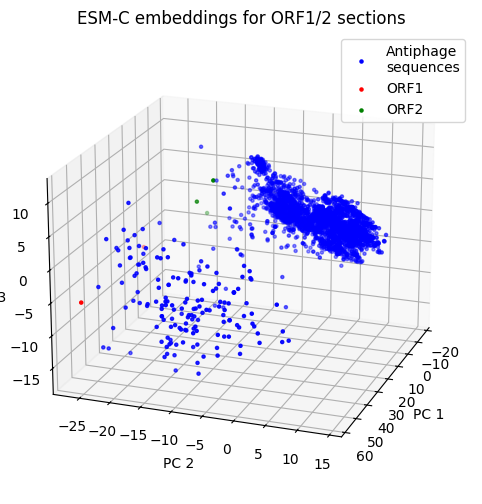

In [38]:
# project all the embeddings to 3D using PCA
pca = PCA(n_components=3)
pca.fit(stacked_mean_embeddings_all)
projected_mean_embeddings = pca.transform(stacked_mean_embeddings_all)
projected_mean_embeddings_enumerate = enumerate(projected_mean_embeddings)

# Plot the clusters using matplotlib in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot all points except the last one
ax.scatter(
    projected_mean_embeddings[:-7, 0],
    projected_mean_embeddings[:-7, 1],
    projected_mean_embeddings[:-7, 2],
    s=5,  # small size for other points
    color='blue',
    label="Antiphage\nsequences"
)

# Highlight the last point (index 775)
ax.scatter(
    projected_mean_embeddings[-6:-4, 0],
    projected_mean_embeddings[-6:-4, 1],
    projected_mean_embeddings[-6:-4, 2],
    s=5,
    color='red',
    label='ORF1'
)

# Highlight the last point (index 775)
ax.scatter(
    projected_mean_embeddings[-3:, 0],
    projected_mean_embeddings[-3:, 1],
    projected_mean_embeddings[-3:, 2],
    s=5,
    color='green',
    label='ORF2'
)

ax.view_init(elev=20, azim=20)  # Adjust the elevation and azimuthal angles for better view

ax.set_title("ESM-C embeddings for ORF1/2 sections")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.legend(loc='upper right')
plt.show()

In [45]:
# Load fasta meta information files
sequence_csv_path = "/home/azureuser/cloudfiles/code/Users/jc62/projects/direct_sequence_analysis/data/ncbi_search_parameters/antiphage_sequences.csv"
sequence_csv_orf_path = "/home/azureuser/cloudfiles/code/Users/jc62/projects/direct_sequence_analysis/data/ncbi_search_parameters/orf1_and_2_sections.csv"
sequence_meta_df = pd.read_csv(sequence_csv_path)
sequence_orf_df = pd.read_csv(sequence_csv_orf_path)

sequences = pd.concat([sequence_meta_df, sequence_orf_df], ignore_index=True)

In [79]:
# Calculate and output distances
number_of_closests = 8
target_embedding_index = 3307  # Index of the target embedding

# Assuming projected_mean_embeddings is a (776, 3) numpy array
target_point = projected_mean_embeddings[target_embedding_index]
distances = np.linalg.norm(projected_mean_embeddings - target_point, axis=1)
output_array = np.column_stack((np.arange(len(distances)), distances))

# Sort by distance
sorted_output = output_array[np.argsort(output_array[:, 1])]

# Get the 5 closest (including the target itself at distance 0)
closests = sorted_output[0:number_of_closests]

# Print the closest sequences and their distances
distance_table = pd.DataFrame(columns=['Index', 'Description', 'Distance'])

for i, (idx, dist) in enumerate(closests, start=1):
    idx = int(idx)
    print(f"{i}: {sequences.loc[idx].description}")
    print(f"Distance: {dist:.4f}\n")
    distance_table.loc[i-1, 'Index'] = idx
    distance_table.loc[i-1, 'Description'] = sequences.loc[idx].description
    distance_table.loc[i-1, 'Distance'] = dist

1: ORF1_wildtype
Distance: 0.0000

2: WP_277528545.1_Hachiman_antiphage_defense_system_protein_HamA_[Pseudomonas_baetica]
Distance: 0.8043

3: WP_432336745.1_Hachiman_antiphage_defense_system_protein_HamA_partial_[Corynebacterium_striatum]
Distance: 1.2560

4: WP_222920731.1_Hachiman_antiphage_defense_system_protein_HamA_partial_[Klebsiella_pneumoniae]
Distance: 1.5937

5: WP_336251087.1_Hachiman_antiphage_defense_system_protein_HamA_partial_[Stomatohabitans_albus]
Distance: 1.8692

6: WP_346010056.1_Hachiman_antiphage_defense_system_protein_HamA_partial_[Pseudomonas_viridiflava]
Distance: 2.1124

7: XUJ37356.1_Hachiman_antiphage_defense_system_protein_HamA_[Bradyrhizobium_japonicum]
Distance: 2.5345

8: WP_316280123.1_Hachiman_antiphage_defense_system_protein_HamA_partial_[Actinomyces_sp.]
Distance: 2.6197

